# Next basket recommendation

The task of next basket recommendation is to predict a content of customers basket at their future purchase.

Task has been assigned as a competition among the students who took the Algorithms of data mining course at Faculty of Information Technology @ Czech Technical University in Prague.

### Scoring function

The competition has been divided into 2 rounds. The difference between rounds is the used scoring function. 1st round scoring function is Jaccard similarity coefficient

$J(A,B) = \frac{ |A \cap B| }{ |A \cup B| }$,

where A is a real basket and B is a predicted one. Final score is a mean of $J(A,B)$ over all predictions. 2nd round scoring function is Generalized Jaccard similarity coefficient over multisets

$J_g(A,B) = \frac{ \sum_i min(a_i, b_i) }{ \sum_i max(a_i, b_i) }$,

where $A$ is a real basket and $B$ is a predicted one. $a_i$ (resp. $b_i$) is number of occurences of $i$-th in $A$ (resp. $B$). Final score is a mean of $J_g(A,B)$ over all predictions. Generalized jaccard index takes into account cases where there is multiple occurrences of same products in one basket. Therefore the scoring function is stricter.

Score in 1st rnd: TBA

Position among others 1st rnd: TBA

Score in 2nd rnd: TBA

Position among others 2nd rnd: TBA

### Disclaimer

Unfortunately I cannot provide the data for the problem as to avoid any legal issues. The data has been provided by a external company in collaboration with the university.



Even though I cannot provide the dataset I will still try to capture my thought process and all the ideas and examples will be shown.


## Dataset

We have been provided with 2 types of csv files.

First file contains 3 columns that together create a order history. The columns are `userid`, `date` and `itemids`. Columns are self-explanatory. `userid` is an ID number of an user, `date` is a date of a purchase and `itemids` is a space separated list of product IDs. Order history files come in 2 sizes. First, the smaller one, contains 1 700 000+ rows. Second file contains total of 8 800 000+ of data.

| userid 	| date       	| itemids           	|
|--------	|------------	|-------------------	|
| 12345  	| 1995-30-7  	| 11111 22222       	|
| 777777 	| 2022-1-1   	| 12314             	|
| 425645 	| 2020-12-31 	| 45646 46511 11111 	|

Second file contains information about products. Each row represents one product. There is 25+ features about each product. Total number of products is 1426. The thoughts about feature selection for products is described later.

| productid 	| features.... 	|
|-----------	|--------------	|
| 11111     	| features     	|
| 22222     	| features     	|


## Data preprocessing

First, I work with smaller dataset. Scaling to full dataset will be done in the end.

In [1]:
# Packages used to preprocess the data
import pandas as pd

For this project I decided to use Featuretools package for automated feature engineering. Featuretools works with typical pandas dataframes, but it's recommended to use `EntitySet` class when working with tabular data with relationships between them. From the previous look at the data We know that there is many to many relationship between order history and products table. Many to many relationships are better decomposed (normalized) to 2 one to many relationships. Now let's separate the data into 3 tables. <b>Orders</b>, <b>Orders Products</b> and <b>Products</b> tables.

In [29]:
df = pd.read_csv('data/train100k.csv') # Read smaller dataset
df.head(3)

,userid,date,itemids
0,7226385,2019-01-22,42203 41183 15823 39620
1,7226385,2019-02-12,54231 14939 39462
2,7226385,2019-03-11,15823 21028 39620 52846


To scale later to bigger dataset I will create function to normalize the train file.

In [30]:
def normalize_train_file(df, return_labels = True):
    """ Normalize train file into Orders and Orders_Products table. """
    orders = ( 
        df.assign(                 
                date=lambda x: pd.to_datetime(x['date'], infer_datetime_format=True),
        )                
        .rename(columns={'userid':'user_id'})
        # Sort orders by date and create unique id for every order
        .set_index(['date'])
        .sort_index()
        .assign(
            id=range(0,len(df))
        )
        # Change types to save memory
        .astype({'user_id':'uint32','id':'uint32'})
        .reset_index()
    )
    # We keep itemids column in orders dataframe to keep the relationship of order id with products

    # labels will be later used to train multilabel classifiers - do not mind them for now
    labels = orders[['id', 'itemids']]

    orders_products = ( 
        orders.drop(columns=['user_id','date'])
        # Split and explode itemids list so that each product will be on individual row, but keep order id
        .assign(product_id=lambda x: x['itemids'].str.split())
        .rename(columns={'id':'order_id'})
        .drop(columns='itemids')
        .explode('product_id')
        .astype({'product_id':'uint16'})        
        .assign(
            id=lambda x: range(0,len(x)) # Creates unique id for every order product pair
        )
        .astype({'id':'uint32'})
    )
    orders_products.index = pd.RangeIndex(len(orders_products.index))
    
    # Lastly drop itemids from orders
    orders = orders.drop(columns=['itemids'])

    if return_labels:
        return orders, orders_products, labels
    return orders, orders_products


orders, orders_products, labels = normalize_train_file(df, return_labels = True)

# Uncomment to save normalized tables for later use
# REQUIRES fastparquet package
#orders.to_parquet(f'data/100k_orders.parquet',engine='fastparquet')
#orders_products.to_parquet(f'data/100k_orders_products.parquet',engine='fastparquet')
#labels.to_parquet(f'data/100k_labels.parquet',engine='fastparquet')

### Preprocessing of products file

Products file takes up about 1.2 MB of space, so the main focus of preprocessing won't be to save memory or disk space by normalizing. The main focus will be on cleaning the data. I won't go into very details of the decision making of the cleaning as it isn't the subject of the task.

In [9]:
products_df = pd.read_csv('data/items.csv')
products_df.head(3)

,itemid,product_name,sim_product_category,sap_product_category,declaration_of_ingredients,nutriscore,country_kitchen,description,main_category_1,main_category_2,...,who_sub,when_main,when_sub,how_main,how_sub,where_main,where_sub,what_main,what_sub,gluten_lactose
0,53048,Wildlachs in Spinatrahmsoße,Fish,Fisch,"Wildlachs 43,7%, Wasser, Vollmilch, Sahne 8,1%...",B,Deutschland,Holen Sie sich ein echtes Gourmet-Menü nach Ha...,Fisch,NaN,...,"{Frauentreff,""Zeit zu Zweit"",Romantisch,weich}","{""Mittagessen / Abendessen""}","{""zum Wein"",""großer Hunger""}","{Alltag,Festlich}","{Kochen,Hauptgang,Zwischengänge}","{""Lunch aufwärmen""}",{},"{Ostern,Karneval,Sommerlich,Winterlich}","{Aschermittwoch,Osterfestessen,Advent,Karfreit...","{""Gluten "",keine_Laktose_Spuren,Laktose,keine_..."
1,11274,Hummercremesuppe,Ready-made,Fisch,NaN,NaN,Deutschland,NaN,Fisch,Fertiggerichte,...,"{Frauentreff,Muttertag,""Zeit zu Zweit"",Romanti...","{""Mittagessen / Abendessen"",Frühstück}","{Brunch,""zum Wein"",Sektfrühstück,Frühschoppen}","{Party,Festlich}","{Vorspeise,Fingerfood}",{},{},"{Ostern,""Frühling "",Herbstlich,Winterlich}","{Erntezeit,Thanksgiving,Osterfestessen,Weihnac...",{}
2,30430,Lachscremesuppe,Ready-made,Fisch,"Wasser, Sahne 18%, Fischfond (Wasser, Fischext...",C,Deutschland,NaN,Fisch,Fertiggerichte,...,"{Schwanger,""ohne Stücke"",Frauentreff,Romantisc...","{""Mittagessen / Abendessen"",Frühstück}","{Brunch,""zum Wein"",""kleiner Hunger"",Snack}","{Party,Festlich}","{Vorspeise,Zwischengänge,Mitternacht}",{},{},"{""Frühling "",Ostern,Karneval,Sommerlich,Winter...","{Osterfestessen,Neujahrsfrühstück,Karfreitag,A...",{}


In [10]:
def drop_missing_data_columns(df, threshold = 0.5):
    """ Drop column of data when more data than threshold percentage is missing."""
    return df.drop(columns=df.columns[(df.count() < threshold * len(df))].to_list())

def drop_columns_matching_regex(df, rxp):
    """ Drop columns of data where the name of the column matches with passed regular expression."""
    return df.drop(columns=df.columns[df.columns.str.contains(rxp, regex=True)].to_list())


In [12]:
products = (
    products_df.pipe(drop_missing_data_columns, threshold = 0.5)
    .pipe(drop_columns_matching_regex, rxp='_main|_sub')
    .drop(columns = ['declaration_of_ingredients', 'description', 'allergens', 'special_ingredients'])
    .rename(columns={'itemid':'id'})
    # Convert features with less than 60 unique values to categorical features
    .astype(
        {
            **dict.fromkeys(df.columns[(df.nunique() < 60)].to_list(), 'category'),
            **{'id':'uint16'}
        }
    )
)

# Uncomment next line to save products table
# REQUIRES fastparquet package
#products.to_parquet('data/products.parquet',engine='fastparquet')

## Entity set

After preprocessing and cleaning the data we can create an EntitySet and add dataframes and build relationships between them. (still working with smaller dataset)

In [32]:
import featuretools as ft
import featuretools.primitives as pr

Load the preprocessed data or skip if in memory.

In [33]:
# Uncomment to read data from saved files
orders = pd.read_parquet('data/100k_orders.parquet')
orders_products = pd.read_parquet('data/100k_orders_products.parquet')
products = pd.read_parquet('data/products.parquet')

Create instance of `EntitySet`. Using the `add_dataframe` method I added our data.

In [34]:
es = ft.EntitySet(id='smaller_dataset')

es.add_dataframe(
    dataframe_name='orders',
    dataframe=orders,
    index='id',
    time_index='date'
)

es.add_dataframe(
    dataframe_name='orders_products',
    dataframe=orders_products,
    index='id'
)

es.add_dataframe(
    dataframe_name='products',
    dataframe=products,
    index='id'
)

Entityset: smaller_dataset
  DataFrames:
    orders [Rows: 1711877, Columns: 3]
    orders_products [Rows: 8454526, Columns: 3]
    products [Rows: 1426, Columns: 11]
  Relationships:
    No relationships

As you can see there are no relationships between the DataFrames. There is `add_relationship` method to add them.

In [35]:
es.add_relationship('products', 'id', 'orders_products', 'product_id')
es.add_relationship('orders', 'id', 'orders_products', 'order_id')

# Create table of users out orders using normalization
es.normalize_dataframe('orders','users','user_id')
es.add_last_time_indexes(['users'])

To plot the structure of `EntitySet` I used `plot` method. It shows format of all the dataframes and relationships between them.

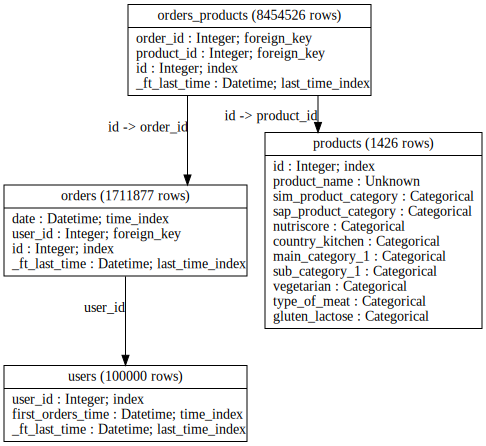

In [36]:
es.plot()

`EntitySet` allows to set interesting values that will later be used in `where` clauses. I add interesting values using `add_interesting_values`.

In [37]:
es.add_interesting_values(dataframe_name="products",
                          values={
                              'vegetarian': ['t', 'f'],
                              'sim_product_category': ['Fish','Ready-made','Snacks', 'Non-food','Vegetables','Potato products','Poultry','Fruit','Other frozen food','Meat','Non-frozen food','Bakery','Ice-cream','Milk products','Desserts']
                          })

## Handling time

Since I want to calculate features for each user at certain point in time, I have to create cutoff times. Calculating features for each user at every order is very expensive even with the size of the smaller dataset. There are 3 ways I will use to reduce the number of cutoff times. The method with the best result will be later used for large dataset. 
1. Take only last `n` order times of each customer.
2. Take `n` random order times of each customer.
3. Use only certain amount of data before each cutoff time. Defined by Timedelta passed as `training_window` argument to `featuretools.dfs`


In [38]:
def create_cutoff(orders, method='all', n=None):
    methods = ['all', 'last', 'sample']
    if method not in methods:
        raise Exception(f'Wrong method. Available methods: {methods}, passed method: {method}.')

    cutoff = orders[['user_id','date']].rename(columns={'date':'time'})
    if method == 'all':
        return cutoff


    if not n:
        raise Exception(f'Passed method "{method}" requires parameter "n" to be set.')

    cutoff = cutoff.groupby('user_id')
    if method == 'last':
        return cutoff.tail(n)
    elif method == 'sample':
        return cutoff.sample(n=n, random_state=42)


Example below shows ~1.7 mil. cutoff times reduced to 300k. Although it is expected that prediction ability should be lower with less data.

In [39]:
cutoff = create_cutoff(orders, method='last', n=3)
cutoff

,user_id,time
59388,5527580,2019-01-25
99593,6418931,2019-02-11
108954,5527580,2019-02-14
121106,5070067,2019-02-19
121413,4885966,2019-02-19
...,...,...
1711872,4631009,2020-12-30
1711873,8480443,2020-12-30
1711874,8381298,2020-12-30
1711875,5086174,2020-12-30


## Creating features and calculating the features matrix

As mentioned feature engineering will be done using `featuretools` package and their `dfs` deep feature synthesis algorithm. Parameters of `dfs` can be found here: https://featuretools.alteryx.com/en/stable/generated/featuretools.dfs.html

In [40]:
def calculate_features(entityset, cutoff, training_window=None, features_only=False, n_jobs=1):
    return ft.dfs(entityset=entityset,
                    target_dataframe_name='users',
                    agg_primitives=[
                        'sum', 'max', 'mean', 'count',
                        'num_unique', 'mode', pr.AvgTimeBetween(unit='days'),
                    ],
                    trans_primitives=[
                        'month','weekday'
                    ],
                    cutoff_time=cutoff,
                    training_window=training_window,
                    approximate=ft.Timedelta(1, unit='d'),
                    max_depth=4,
                    n_jobs=n_jobs,
                    ignore_columns={'users':['first_orders_time']},
                    verbose=True,
                    features_only=features_only,
                    include_cutoff_time=False)

In [ ]:
cutoff = create_cutoff(orders, method='last', n=1)
features = calculate_features(es, cutoff, features_only=True)
features

## Machine learning

Work in progress

https://scikit-learn.org/stable/modules/multiclass.html

## Scaling to larger dataset